In [1]:
from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm
import re
import pdb

In [2]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.57', '1.1.0')

In [3]:
torch.cuda.set_device(0)

In [4]:
!pwd

/home/gaurav/PycharmProjects/nlp-for-gujarati/classification


In [5]:
path = Path('/home/gaurav/PycharmProjects/nlp-for-gujarati/classification')

In [6]:
train_df = pd.read_csv(path/'train.csv')
train_df.head()

,headline,label
0,મોદી સરકાર 1 ફેબ્રુઆરીએ વચગાળાનું બજેટ રજૂ કરશ...,business
1,LIC પોલિસી ધારકો માટે મોટી ખબર! પ્રીમિયમ જમા ક...,business
2,"VIRAL VIDEO: મસ્તમૌલા અંદાજમાં રણવીર સિંહ, ચાર...",entertainment
3,શાહરૂખની સાથે ફિલ્મમાં કામ કરી ચુક્યો છે અનુષ્...,entertainment
4,એકદમ બટરફ્લાઇ અવતારમાં જોવા મળી આ એક્ટ્રેસ,entertainment


In [7]:
valid_df = pd.read_csv(path/'valid.csv')
valid_df.head()

,headline,label
0,IT ડિપાર્ટમેન્ટ 1 લાખ લોકો સામે કરશે દંડનાત્મક...,business
1,"વિરાટની સેન્ચુરી પર અનુષ્કા ખુશ, ઇન્સ્ટાગ્રામ ...",entertainment
2,'જમાઇ રાજા' ની આ હોટ એકટ્રેસના બિકિની ફોટાએ લગ...,entertainment
3,"કરીનાએ સૈફના બર્થડે પર રાખી સ્પેશિયલ પાર્ટી, જ...",entertainment
4,"ભારતમાં નોકરી કરવા માટે બેસ્ટ છે આ કંપની, શું ...",business


In [8]:
print('In Training data:')
for cls in train_df['label'].unique():
    print(cls, (train_df['label'] == cls).sum())

In Training data:
business 1840
entertainment 2321
tech 1108


In [9]:
print('In Validation data:')
for cls in valid_df['label'].unique():
    print(cls, (valid_df['label'] == cls).sum())

In Validation data:
business 491
entertainment 584
tech 243


In [10]:
train_df['headline'][0]

'મોદી સરકાર 1 ફેબ્રુઆરીએ વચગાળાનું બજેટ રજૂ કરશે, આ જાહેરાતો થઈ શકે'

In [11]:
train_df.shape, valid_df.shape

((5269, 2), (1318, 2))

In [13]:
train_df[train_df['label'].isnull()].shape, valid_df[valid_df['label'].isnull()].shape

((0, 2), (0, 2))

In [14]:
label_cols = list(range(1,train_df.shape[1]))

In [15]:
print(label_cols)

[1]


In [16]:
id_to_col = list(train_df.columns)

In [17]:
col_to_id = {}
for i, col in enumerate(id_to_col):
    col_to_id[col] = i

In [18]:
class GujaratiTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str(path/"../tokenizer/gujarati_lm.model"))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [19]:
sp = spm.SentencePieceProcessor()
sp.Load(str(path/"../tokenizer/gujarati_lm.model"))
itos = [sp.IdToPiece(int(i)) for i in range(20000)]

In [20]:
itos[:10]

['<unk>', '<s>', '</s>', '.', ',', '▁છે', '▁', '▁અને', 'ની', 'માં']

In [21]:
# 20,000 is the vocab size that we chose in sentencepiece
gujarati_vocab = Vocab(itos)

In [22]:
tokenizer = Tokenizer(tok_func=GujaratiTokenizer, lang='gu')

In [23]:
tokenizer.special_cases

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep']

In [29]:
data_lm = TextLMDataBunch.from_df(path=path, train_df=train_df, valid_df=valid_df, text_cols=[0], label_cols=label_cols, tokenizer=tokenizer, vocab=gujarati_vocab, bs=16)

In [30]:
data_lm.save()

In [31]:
data_lm.show_batch()

idx,text
0,"▁ચૈ પ લિન ને ▁આ ▁રીતે ▁આપ્યું ▁ટ્રી બ ્યુટ ▁x x bo s ▁શાહરૂખ ની ▁સાથે ▁ફિલ્મમાં ▁કામ ▁કરી ▁ચુક ્યો ▁છે ▁અનુ ષ્ કા થી ▁ઠ પ કો ▁ખાધ ેલો ▁વ્યક્તિ ▁x x bo s ▁એક દમ ▁બ ટર ફ્ લાઇ ▁અવતાર માં ▁જોવા ▁મળી ▁આ ▁એક્ટ ્રે સ ▁x x bo s ▁આજે ▁અહી થી ▁ખરીદ ો ▁one p lu s ▁6 , ▁મળશે ▁2 5,000 ▁રૂપિયા"
1,"▁કરો ▁ચોકલેટ ▁બિઝનેસ , ▁થશે ▁લા કો ની ▁કમાણી ! ▁x x bo s ▁માત્ર ▁ત્રણ ▁કલાક માં ▁જ ▁કરી ▁દેશ ની ▁સૌથી ▁મોટી ▁બેંક ની ▁સાઇટ ▁હે ક ▁x x bo s <unk> ▁t c s નું ▁માર્કેટ ▁કેપ ▁8 ▁લાખ ▁કરોડ ને ▁પાર , ▁હવે ▁રિલાયન્સ ▁બીજા ▁નંબર ે ▁x x bo s ▁કિ મ ▁કાર્ દિ શિયન ે ▁હવે ▁પોતાની <unk> ▁n ud e ▁bo d y"
2,"ia ▁9 ▁? ▁x x bo s <unk> mi ▁no te ▁7 ▁ભારતમાં ▁આ ▁તારીખે ▁થશે ▁લોન્ચ , ▁કંપનીએ ▁કર્યો ▁ખુલાસો ▁x x bo s ▁જ્યારે ▁એપલ ની ▁ઘડિયાળ ે ▁બચાવી ▁એક ▁માણસ ની ▁જિંદગી ▁x x bo s ▁રાજકોટ ઃ ભાવ માં ▁ધ રખમ ▁ઘટાડો ▁થતાં ▁કેસર ▁કેરી નો ▁સ્વાદ ▁હવે ▁મીઠો ▁લાગ શે ▁x x bo s ▁ને હા ▁શર્મા એ ▁સોશિયલ ▁મીડિયા ▁પર ▁શેર ▁કરી ▁બોલ ્ડ"
3,"િંગ નું ▁નવ ુ ▁પોસ્ટ ર ▁રિલીઝ , <unk> ▁b ik in i <unk> ▁l ook માં ▁નજર ▁આવી ▁સોન મ , ▁કરી ના , ▁સ્વ રા ▁અને ▁શિખ ા ▁x x bo s ▁આ ▁એક્ટ ્રે સે ▁સોશિયલ ▁મીડિયા ▁પર ▁લગાવી ▁આગ , ▁પોસ્ટ ▁કરી ▁જબરદસ્ત ▁હોટ ▁તસવીરો ▁x x bo s ▁કપિલ ▁શર્મા એ ▁કહ્યું , ▁ગાળો ▁ભાંડ ી ને ▁કાઢ ુ ▁છુ ▁ગુસ્સ ો , ▁એક ▁મહિના"
4,"bo s <unk> ▁s b i ની ▁મોટી ▁ઓફર ઃ ▁મફત માં ▁મળી ▁રહ્યું ▁છે ▁પાંચ ▁લી ટર ▁પેટ્રોલ ! ▁જાણ ો ▁પ્રોસેસ ▁x x bo s <unk> ▁e x c l <unk> us <unk> iv e : ▁ટૂંક ▁સમયમાં ▁ઘટી ▁શકે ▁છે ▁પેટ્રોલ - ડી ઝ લ ના ▁ભાવ , ▁સરકાર ▁લેશે ▁પગલાં ▁x x bo s ▁' જ ન્નત ' ▁ગર્લ ▁સોન લ ▁ચૌહાણ ▁મન મો હ ક"


In [32]:
awd_lstm_config = awd_lstm_lm_config.copy()
awd_lstm_config['n_hid'] = 1150
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.3, config=awd_lstm_config, pretrained=False)

In [33]:
# Loading the pretrained language model on gujarati wikipedia
learn.load('/home/gaurav/PycharmProjects/nlp-for-gujarati/language-model/GujaratiDataset/models/third_gu_lm', with_opt=True)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (5269 items)
x: LMTextList
▁x x bo s ▁મોદી ▁સરકાર ▁1 ▁ફેબ્રુઆરી એ ▁વચગાળા નું ▁બજેટ ▁રજૂ ▁કરશે , ▁આ ▁જાહેરાતો ▁થઈ ▁શકે,▁x x bo s <unk> ▁l <unk> ic ▁પોલિસી ▁ ધારકો ▁માટે ▁મોટી ▁ખબર ! ▁પ્રી મ િયમ ▁જમા ▁કરવાનો ▁નિયમ ▁બદલાય ો,▁x x bo s <unk> ▁v i r a l <unk> ▁v i d e o : ▁મસ્ત મ ૌ લા ▁અંદાજ માં ▁રણ વીર ▁સિંહ , ▁ચાર્લી ▁ચૈ પ લિન ને ▁આ ▁રીતે ▁આપ્યું ▁ટ્રી બ ્યુટ,▁x x bo s ▁શાહરૂખ ની ▁સાથે ▁ફિલ્મમાં ▁કામ ▁કરી ▁ચુક ્યો ▁છે ▁અનુ ષ્ કા થી ▁ઠ પ કો ▁ખાધ ેલો ▁વ્યક્તિ,▁x x bo s ▁એક દમ ▁બ ટર ફ્ લાઇ ▁અવતાર માં ▁જોવા ▁મળી ▁આ ▁એક્ટ ્રે સ
y: LMLabelList
,,,,
Path: /home/gaurav/PycharmProjects/nlp-for-gujarati/classification;

Valid: LabelList (1318 items)
x: LMTextList
▁x x bo s ▁ <unk> it ▁ડિપાર્ટમેન્ટ ▁1 ▁લાખ ▁લોકો ▁સામે ▁કરશે ▁દંડ ના ત્મક ▁કાર્યવાહી,▁x x bo s ▁વિરાટ ની ▁સેન્ ચુર ી ▁પર ▁અનુ ષ્ કા ▁ખુશ , ▁ઇન્ સ્ટા ગ્રામ ▁પર ▁આવી ▁રીતે ▁વરસ ા વ્યો ▁પ્રેમ,▁x x bo s ▁' જ મા ઇ ▁રાજા ' ▁ની ▁આ ▁હોટ ▁એક ટ્રે સના ▁બિ કિ ની ▁ફોટા એ ▁લગાવી ▁' આ ગ ',▁x x bo s

In [34]:
# Fine tuning the prtrained LM on current dataset

In [35]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


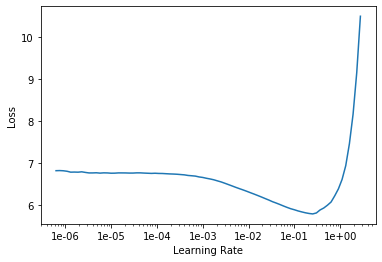

In [36]:
learn.recorder.plot()

In [37]:
learn.freeze()

In [38]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,5.134665,4.720959,0.295408,00:08


In [39]:
learn.unfreeze()

In [40]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.356037,4.336496,0.327615,00:09
1,3.993542,4.050807,0.364477,00:09
2,3.661298,3.944021,0.381441,00:09
3,3.397039,3.928034,0.385682,00:09
4,3.249881,3.936134,0.386001,00:09


In [41]:
learn.predict('શાહરૂખ ખાન સાથે',n_words=10)

'શાહરૂખ ખાન સાથે ▁પાટ િના ▁પર ▁આરોપ ાતો ▁હવે ▁હવે ▁આરોપ ▁x x'

In [42]:
learn.save_encoder('fine_tuned_enc')

In [43]:
data_clas = TextClasDataBunch.from_df(path=path, train_df=train_df, valid_df=valid_df, tokenizer=tokenizer, vocab=gujarati_vocab, text_cols=[0], label_cols=label_cols, bs=16)

In [44]:
data_clas.show_batch()

text,target
▁x x bo s <unk> ▁t r a i l e r <unk> <unk> u t : ▁જુઓ ▁' z e r o ' માં ▁શાહરૂખ - ▁અનુ ષ્ કા ▁અને ▁સેક્સ ી ▁કે ટર િના નું <unk> ▁l o v e <unk> ▁t r i a n g l e,entertainment
"▁x x bo s <unk> <unk> l <unk> ▁b e t t i n g ▁ <unk> ca <unk> se : ▁ખુ લી ▁બોલિવૂડ ની ▁પોલ , ▁અરબ ા ઝ ▁ખાન ▁પછી ▁વધુ ▁બે ▁પ્રો ડ ્યુ સર નાં ▁નામ ▁ખુલ્ યાં",entertainment
"▁x x bo s <unk> ▁a ma z on ▁પર ▁ચાલી ▁રહી ▁છે <unk> ▁a pp le <unk> ▁f est , ▁i p h one ▁ x થી ▁લઇને ▁i p h one ▁ <unk> <unk> ▁સુધી ▁ભારે ▁ડિસ્ક ાઉ ન્ટ",tech
"▁x x bo s <unk> ▁v i d e o : ▁ઉર્ મિ લા ▁બાદ ▁હવે ▁એ લી એ ▁કહ્યું , ▁' છ મ્મા ▁છ મ્મા ' , ▁એક્ટ ્રે સે ▁લગાવ ્યા ▁હોટ ને સ નાં ▁તડક ા",entertainment
▁x x bo s <unk> ▁co n g r a t u l a t i o n s ! ▁સેક્સ ▁સ્કેન્ડ લ માં ▁પકડ ાયેલી ▁શ્વેત ા ▁બસ ુ એ ▁કરી ▁' સિ ક્રેટ ▁સગા ઇ ',entertainment


In [45]:
del awd_lstm_config['tie_weights']
del awd_lstm_config['out_bias']

In [46]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5, config=awd_lstm_config)

In [47]:
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (5269 items)
x: TextList
▁x x bo s ▁મોદી ▁સરકાર ▁1 ▁ફેબ્રુઆરી એ ▁વચગાળા નું ▁બજેટ ▁રજૂ ▁કરશે , ▁આ ▁જાહેરાતો ▁થઈ ▁શકે,▁x x bo s <unk> ▁l <unk> ic ▁પોલિસી ▁ ધારકો ▁માટે ▁મોટી ▁ખબર ! ▁પ્રી મ િયમ ▁જમા ▁કરવાનો ▁નિયમ ▁બદલાય ો,▁x x bo s <unk> ▁v i r a l <unk> ▁v i d e o : ▁મસ્ત મ ૌ લા ▁અંદાજ માં ▁રણ વીર ▁સિંહ , ▁ચાર્લી ▁ચૈ પ લિન ને ▁આ ▁રીતે ▁આપ્યું ▁ટ્રી બ ્યુટ,▁x x bo s ▁શાહરૂખ ની ▁સાથે ▁ફિલ્મમાં ▁કામ ▁કરી ▁ચુક ્યો ▁છે ▁અનુ ષ્ કા થી ▁ઠ પ કો ▁ખાધ ેલો ▁વ્યક્તિ,▁x x bo s ▁એક દમ ▁બ ટર ફ્ લાઇ ▁અવતાર માં ▁જોવા ▁મળી ▁આ ▁એક્ટ ્રે સ
y: CategoryList
business,business,entertainment,entertainment,entertainment
Path: /home/gaurav/PycharmProjects/nlp-for-gujarati/classification;

Valid: LabelList (1318 items)
x: TextList
▁x x bo s ▁ <unk> it ▁ડિપાર્ટમેન્ટ ▁1 ▁લાખ ▁લોકો ▁સામે ▁કરશે ▁દંડ ના ત્મક ▁કાર્યવાહી,▁x x bo s ▁વિરાટ ની ▁સેન્ ચુર ી ▁પર ▁અનુ ષ્ કા ▁ખુશ , ▁ઇન્ સ્ટા ગ્રામ ▁પર ▁આવી ▁રીતે ▁વરસ ા વ્યો ▁પ્રેમ,▁x x bo s ▁' જ મા ઇ ▁રાજા ' ▁ની ▁આ ▁હોટ ▁એક ટ્ર

In [48]:
learn.freeze()

In [49]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


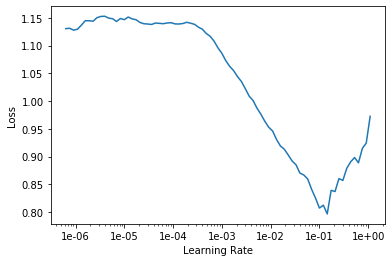

In [50]:
learn.recorder.plot()

In [51]:
learn.loss_func.func

CrossEntropyLoss()

In [52]:
kappa = KappaScore()

In [53]:
learn.metrics = [kappa, accuracy]

In [54]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.454331,0.338667,0.798111,0.873293,00:06


In [55]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.384875,0.286631,0.842950,0.900607,00:07


In [56]:
learn.save('second-full')

In [57]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3, callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='accuracy', name='final')])

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.274133,0.254475,0.850016,0.905159,00:12
1,0.200794,0.247230,0.879023,0.924127,00:12
2,0.109039,0.274052,0.876848,0.922610,00:12
3,0.059068,0.286788,0.876294,0.921851,00:12
4,0.052125,0.306883,0.870322,0.918058,00:12


Better model found at epoch 0 with accuracy value: 0.9051593542098999.
Better model found at epoch 1 with accuracy value: 0.924127459526062.


In [58]:
learn.predict('પ્રિયંકા ચોપડાને પતિ નિક પાસેથી મળી 2.7 કરોડ રૂપિયાની ગિફ્ટ, કિસ કરીને બોલી- લવ યૂ બેબી')

(Category entertainment, tensor(1), tensor([0.0455, 0.9419, 0.0126]))

In [59]:
learn.predict("કલંકઃ 21 વર્ષ બાદ એકસાથે જોવા મળશે સંજય દત્ત-માધુરી દિક્ષિત, કહી દિલની વાત")

(Category entertainment,
 tensor(1),
 tensor([7.5419e-04, 9.9901e-01, 2.3195e-04]))

In [60]:
learn.predict("બે અઠવાડિયા બાદ સસ્તું થયું પેટ્રોલ, ડીઝલની કિંમત પણ ઘટી")

(Category business, tensor(0), tensor([0.9922, 0.0029, 0.0050]))

In [61]:
learn.predict("જનકલી નોટો ઓળખવા માટે એક નવી સ્માર્ટફોન એપ આવી")

(Category tech, tensor(2), tensor([0.2275, 0.0025, 0.7700]))